# "HERALDO.py"
## _Holography using Extended References, And Linear Differential Operator_

Holography is the study of holograms. A hologram is an object that diffracts coherent light into an image. In the case of experiments, the diffraction pattern is what we measure, but the hologram is what we are interested in. So _reconstruction_ of the hologram is required. This script shows how to use the heraldo.py package to reconstruct the magnetic contrast from XMCD measurements, while at the same time explaining the theory of the reconstruction and touching on the physics of the experiment.

In [1]:
# math operations & array maniputlation
import heraldo_core as he
import scipy as sp
import scipy.fftpack as fftpack
import scipy.ndimage as ndimage

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib notebook

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Diffraction patterns

Coherent X-rays packets are focussed onto the hologram target, which consists of a narrow reference slit, and a circular aperture that exposes the sample. The X-rays are then scattered, forming a diffraction pattern on the CCD. Huygen's princple simply tells us that at the far field diffraction pattern due to an aperture, is the spatial fourier transform of that aperture. The raw data is the measured intensity of the diffraction pattern, which is equal to,

$$ I\left(k_x,k_y\right) = \mathcal{F}\left\{R*R^* + S*S^* + S*R^* + S^**R \right\} $$

where $\mathcal{F}$ is the 2D Fourier transform, $S$ is the sample and $R$ is the reference slit, both in real space. This can be derived easily using the convolution theorem. The aim is to deconvolve the this expression to find the sample, $S$.

## Loading data

The intensity of the diffraction pattern is saved in _.nxs_ files. These are HDF files, named by the order in which they're collected; ie "scan_001.nxs". To load the raw measured diffraction patterns, the __load_nxs_data()__ function can be used. It requires the relative path to the directory containing the data, the name of the file, the group within the file that contains the desired dataset and the name of the dataset.

In [2]:
raw_1 = he.load_nxs_data('/Users/Angus_Laurenson/ownCloud/HERALDO_09_17/Polarity Switching/','scan_043.nxs','scannxs_043','data_16')
raw_2 = he.load_nxs_data('/Users/Angus_Laurenson/ownCloud/HERALDO_09_17/Polarity Switching/','scan_044.nxs','scannxs_044','data_16')

## XMCD and subtraction

Magnetic contrast originates from the X-ray Magnetic Circular Dichroism, where the absorbtion of X-rays parallel to the magnetisation depends on the circular polarisation of the X-rays. This is because the non-reciprocal gyration of magnetisation introduces a off diagonal (gyrotropic) magnetic suceptibility that means one chirality of circular polarisation is absorbed more than another. Thus the difference between the diffraction patterns from the left and right circularly polarised X-rays contains the magnetic information. The subtraction also helps to remove the non-magnetic information, clearing up the signal.

Odd and Even scan numbers correspond to opposite chiralities in polarisation, thus we always load data sets in pairs.

In [3]:
sum_data = he.norm(raw_1)+he.norm(raw_2); dif_data = he.norm(raw_1)-he.norm(raw_2)

## Calibration

In order to make an accurate reconstruction, the misalignment of the diffraction pattern data with the shape of the array must be characterised, so that it can be compensated for. For this we need the angle of the diffraction line, in order to apply the differential filter, and the location of the diffraction centre so that phase shift correction be applied to account for the offset fourier transform.

### Offset

To estimate the centre of the diffraction pattern, a circle is fitted to the diffraction rings emenating from the beam stop. More specifically, the image is blurred and squared, then a canny edge detector is used to make a binary image of lines. Finally a circle is fitted using RANSAC to disgard the outliers. The centre of this circle is taken to be the origin of the diffraction pattern. It works best on the sum of the two datasets.

the second argument is the standard deviation of the gaussian blur filter used before fitting

In [4]:
origin = he.get_offset(sum_data, 5)

### Angle

The angle of the reference slit's diffraction line found by fitting a straight line to the data. By taking the maximum values of the smoothed images, a line is fitted using least squares and the angle calculated using arctan.

In [5]:
angle = he.get_angle(sum_data)
print(angle)

0.04858884125442347


### Display the callibration

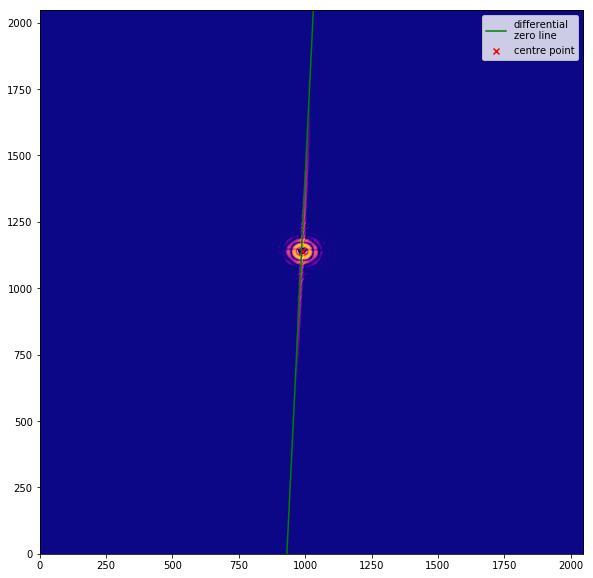

In [6]:
# display the callibration
plt.figure(figsize=(10,10))
plt.imshow(ndimage.gaussian_filter(sum_data,0),
           norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03),
           origin='lower',
           cmap = 'plasma',
            interpolation='None'
          )
plt.scatter(origin[0],origin[1], color='red', marker='x', label='centre point')
plt.plot(sp.tan(angle) * sp.arange(sum_data.shape[0])
         + origin[0] - sp.tan(angle) * origin[1],
        sp.arange(sum_data.shape[0]),
        color='green',
         label='differential\nzero line',
        )

plt.xlim(0,sum_data.shape[0])
plt.ylim(0,sum_data.shape[1])
plt.legend()
plt.show()


## Differential filter

We aim to reconstruct the sample by deconvoluting it from the reference. Part of the diffraction pattern is the fourier transform of the cross correlation of the sample with the slit, see the first equation.

In real space, as the reference is a finite line, the sample image is smeared along the direction of the line. By differentiating in this direction we get the changes in intensity only, which reveals two images of the sample.

Instead of applying the gradient operation along the line in real space, it is convenient to do it directly to the diffraction image. Real space differentiation, when expressed in reciprocal space is a constant gradient.

$$ \frac{d}{dx} = i2\pi k $$

The differential filter function, creates an array of constant gradient, perpendicular to the reference diffraction line and with the contour equal to zero colinear with it.

In [7]:
filtered_data = dif_data*he.differential_filter(dif_data, angle, origin)

## Inverse fourier transform from diffraction image to real space

As the diffraction pattern is the a fourier transform of the apertures, an inverse fourier transform returns the data into real space

In [8]:
filtered_data = fftpack.fftshift(fftpack.fft2(filtered_data))

## Phase correction filter

Finally a constant phase is added to the image in order to account for the offset between the array origin and the centre of the diffraction pattern. A signal that is offset from zero will carry an additional phase when Fourier transformed, the Fourier shift theorem.

$$ \int f(x)e^{ik'x}e^{ikx}dx = \mathcal{F}(k-k') $$

To account for this shift we apply a filter $e^{-ik'x}, where $k'$ is the offset of the diffraction pattern centre from the origin of the array.

In [9]:
final_data = he.phase_correction(filtered_data, origin)

## Displace final reconstruction

Now that the phase correction has been applied to the real space, filtered data. We can interpret the magnetic contrast. We see at the centre the autocorrelation of the sample and aperature with itself, whilst on opposite diagonals we see the sample and aperture deconvovled from the reference slit. It is these satelite images which reveal that our sample is a square landau vortex state.

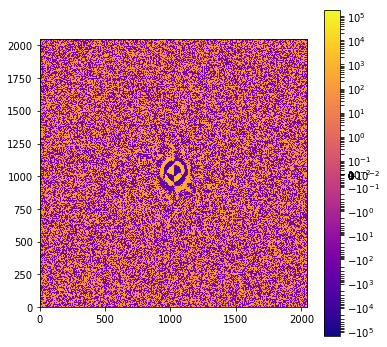

In [10]:
# display the final recontructed data

plt.figure(figsize=(6,6))
plt.imshow(ndimage.gaussian_filter(final_data.real,0),
           norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03),
           origin='lower',
           cmap = 'plasma'
          )
plt.colorbar()
plt.show()

A closeup look clearly shows the distinctive magnetic contrast of a Landau pattern square vortex.

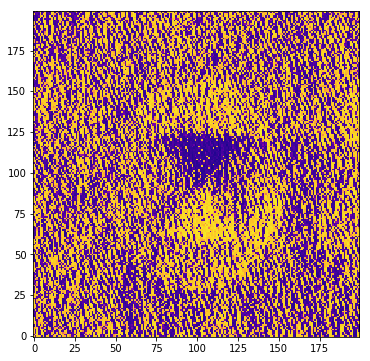

In [11]:
# Plot a closeup of the magnetic contrast of the sample

plt.figure(figsize=(6,6))
plt.imshow(final_data.real[1050:1250,650:850],
           norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03),
           origin='lower',
           cmap = 'plasma'
          )
plt.show()

Finally a wrapper function does it all in a oner, returning the complex reconstruction array.

In [12]:
final_image = he.reconstruct('/Users/Angus_Laurenson/ownCloud/HERALDO_09_17/Polarity Switching/','scan_043.nxs','scan_044.nxs',5)

KeyError: "Unable to open object (object 'scanx_043' doesn't exist)"

In [13]:
print(final_image.dtype)
from PIL import Image
im = Image.fromarray(sp.uint8(sp.absolute(final_image)*255))
im.show()

NameError: name 'final_image' is not defined

In [14]:
help(plt.savefig)

Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, dpi=None, facecolor='w', edgecolor='w',
              orientation='portrait', papertype=None, format=None,
              transparent=False, bbox_inches=None, pad_inches=0.1,
              frameon=None)
    
    The output formats available depend on the backend being used.
    
    Parameters
    ----------
    
    fname : str or file-like object
        A string containing a path to a filename, or a Python
        file-like object, or possibly some backend-dependent object
        such as :class:`~matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is *None* and *fname* is a string, the output
        format is deduced from the extension of the filename. If
        the filename has no extension, the value of the rc parameter
        ``savefig.format`` is used.
    
        If *fname* is not a string, remember 

<IPython.core.display.Javascript object>


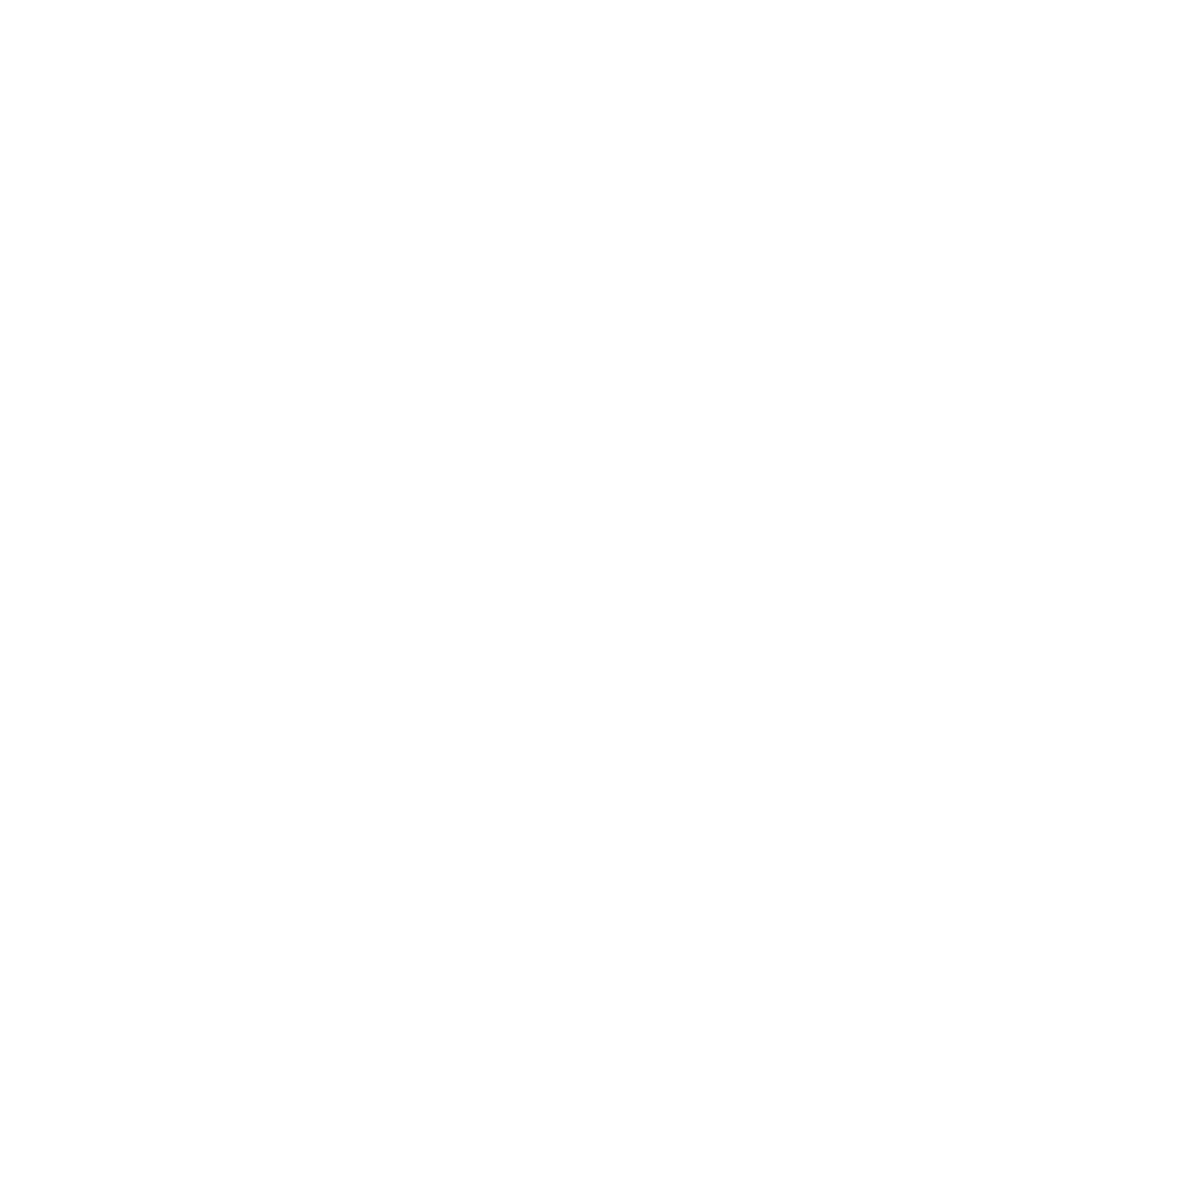

NameError: name 'final_image' is not defined

In [15]:
# Plot a closeup of the magnetic contrast of the sample
%matplotlib notebook
plt.figure(figsize=(6,6))
# plt.imshow(sp.uint8(sp.absolute(final_image)*255),
plt.imshow(sp.angle(final_image)[800:1250,650:1400],
           norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03),
           origin='lower',
           cmap = 'plasma'
          )
plt.savefig('test.png')
plt.show()

### Reconstruct all .nxs pairs in a directory
Here we make a list of all .nxs files in a directory, then work through them in pairs reconstructing the hologram and saving the output using the name of the input files

In [16]:
cd /Users/Angus_Laurenson/ownCloud/HERALDO_09_17/Polarity\ Switching

/Users/Angus_Laurenson/ownCloud/HERALDO_09_17/Polarity Switching


In [17]:
# %%prun -T batch_reconstruction.txt
# %matplotlib inline
# nxs_files = !ls *nxs
# for n in range(int(len(nxs_files)/2)):
#     folder = '/Users/Angus_Laurenson/ownCloud/HERALDO_09_17/Polarity Switching/';
#     data = he.reconstruct(folder,nxs_files[2*n],nxs_files[2*n+1], 5)
#     plt.figure();
#     plt.imshow(sp.angle(final_image)[800:1250,650:1400],
#        norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03),
#        origin='lower',
#        cmap = 'plasma'
#     )
#     plt.savefig(folder + nxs_files[2*n].split('_')[1].split('.')[0]+'.png')

In [18]:
# from PIL import Image
# from matplotlib import cm
# data = he.reconstruct('/Users/Angus_Laurenson/ownCloud/HERALDO_09_17/Polarity Switching/','scan_043.nxs','scan_044.nxs', 5)
# # normalise image
# data = sp.angle(data)/sp.amax(sp.angle(data))
# im = Image.fromarray(sp.uint8(cm.hsv(data[800:1250,650:1400])*255))
# im.save('test.png')

In [19]:
# %%prun -T batch_reconstruction_PIL.txt
# %matplotlib inline
# nxs_files = !ls *nxs
# for n in range(int(len(nxs_files)/2)):
#     folder = '/Users/Angus_Laurenson/ownCloud/HERALDO_09_17/Polarity Switching/';
#     data = he.reconstruct(folder,nxs_files[2*n],nxs_files[2*n+1], 5)
#     data = sp.angle(data)/sp.amax(sp.angle(data))
#     im = Image.fromarray(sp.uint8(cm.hsv(data[800:1250,650:1400])*255))
#     im.save(folder + nxs_files[2*n].split('_')[1].split('.')[0]+'_PIL.png')

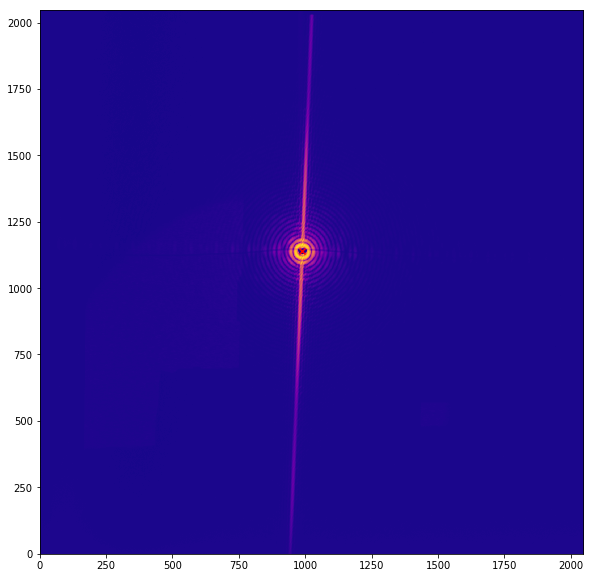

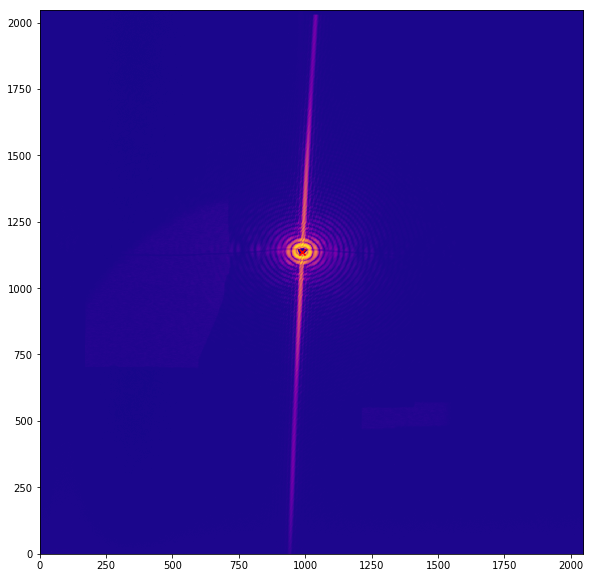

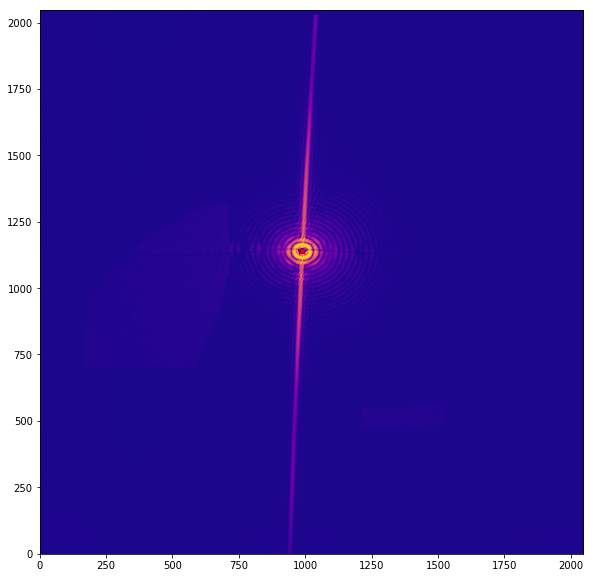

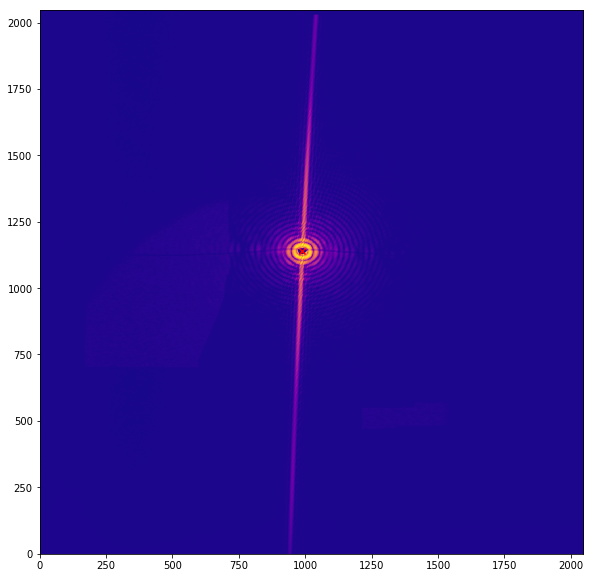

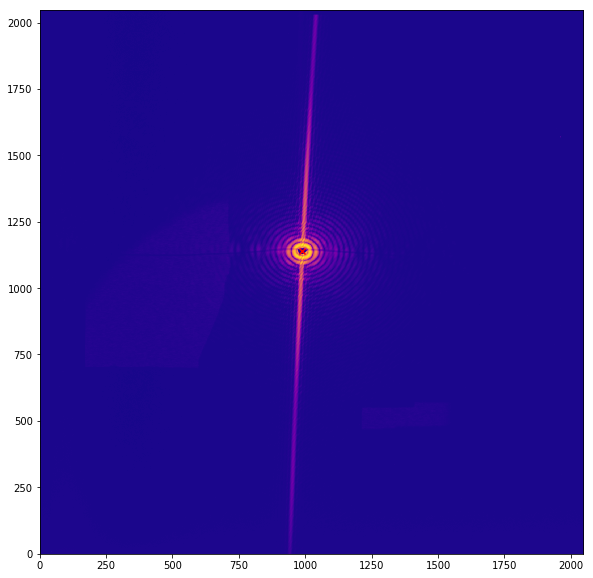

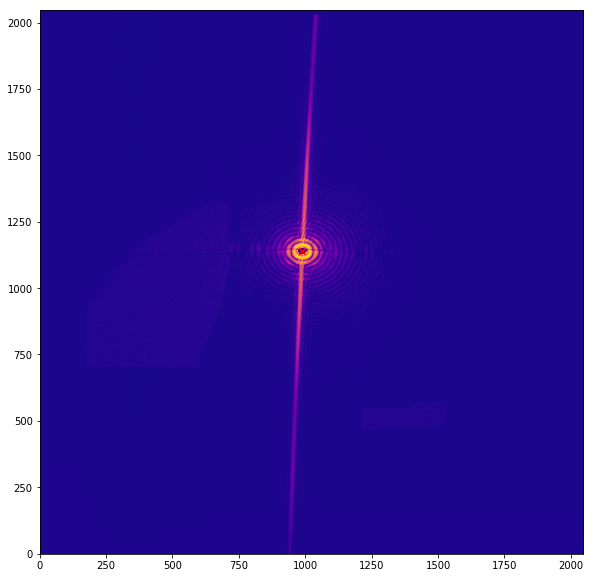

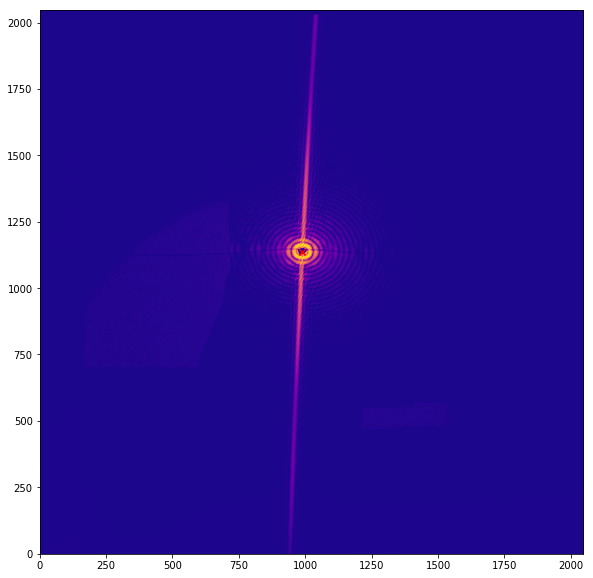

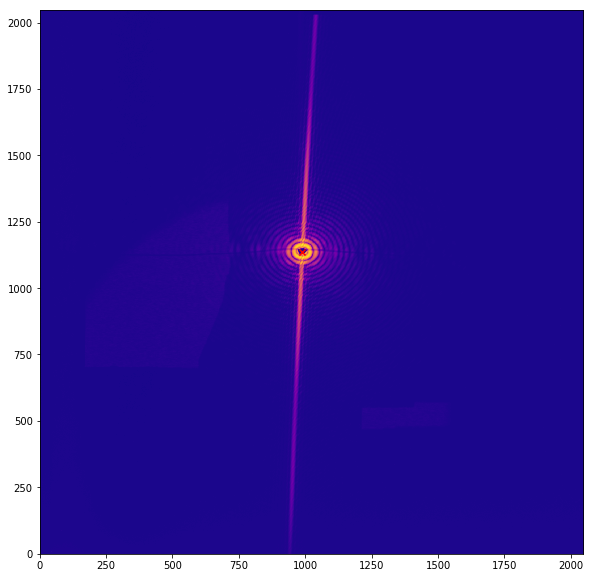

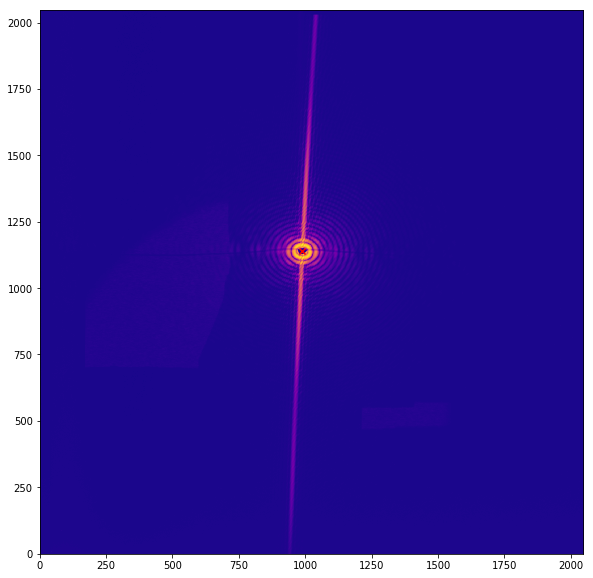

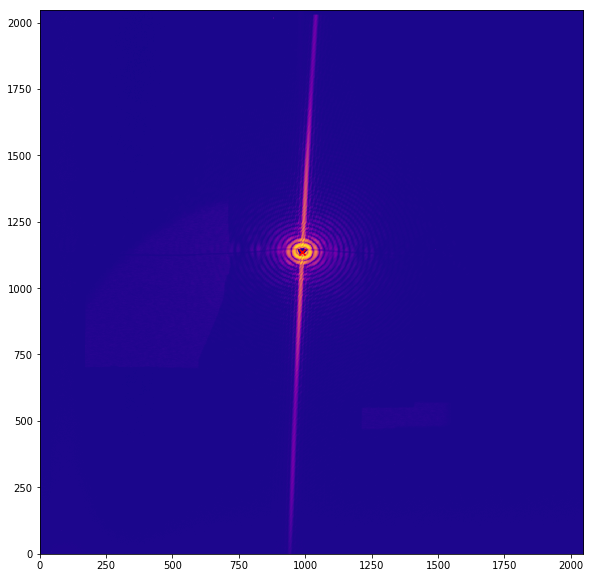

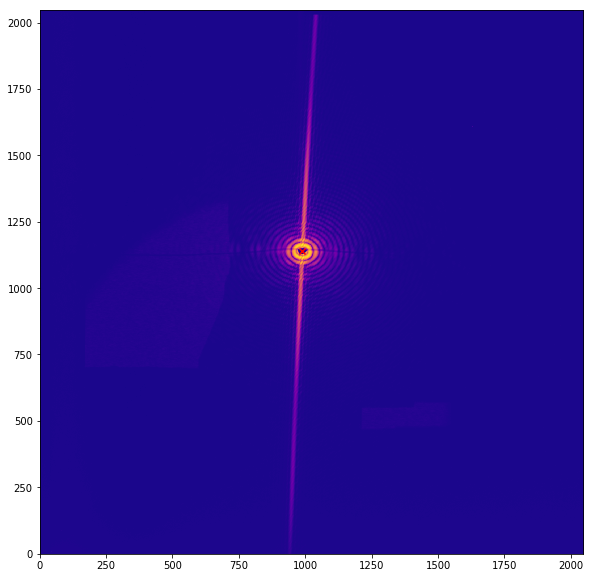

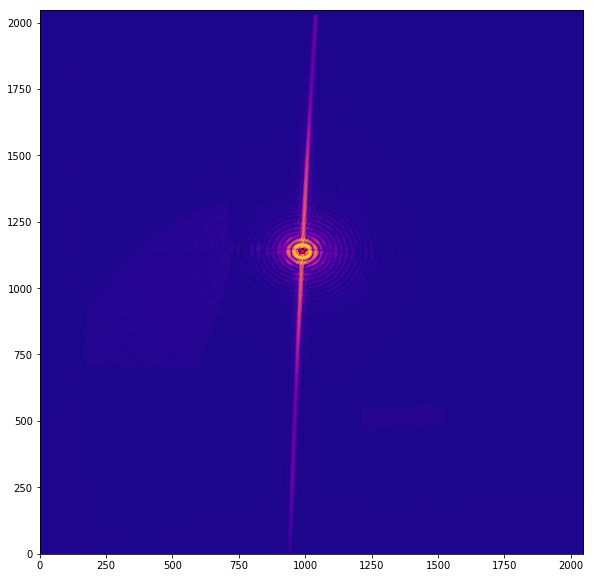

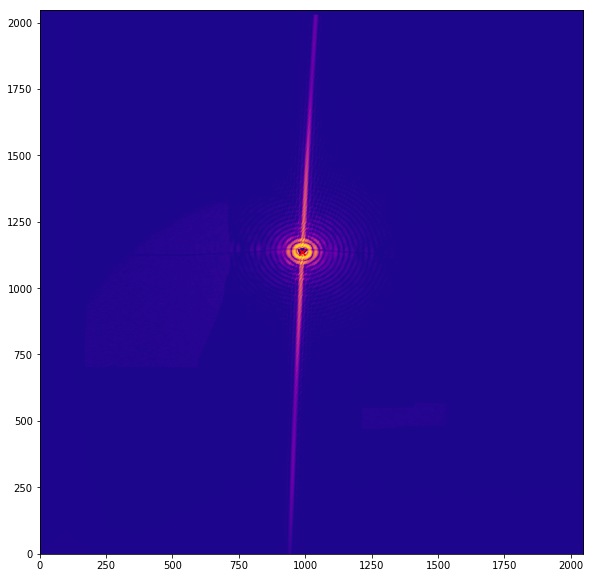

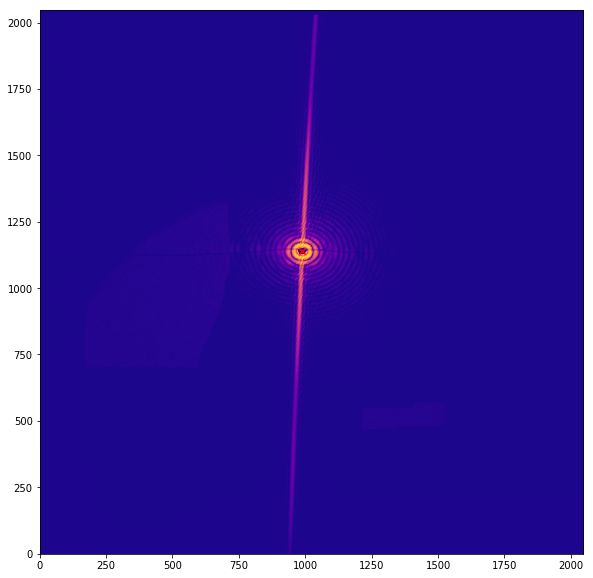

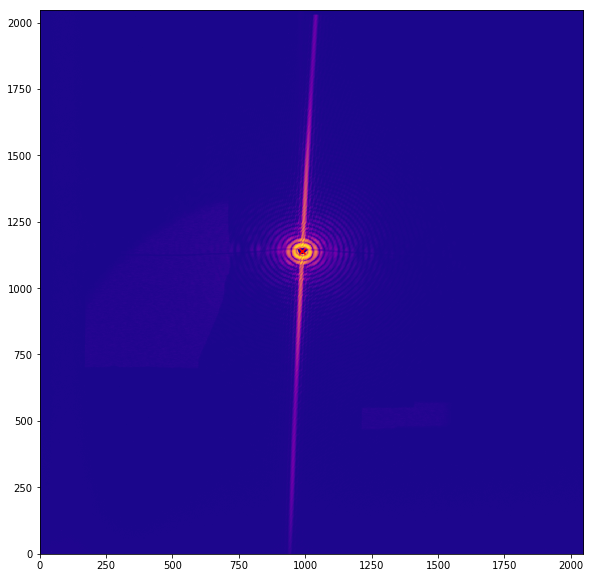

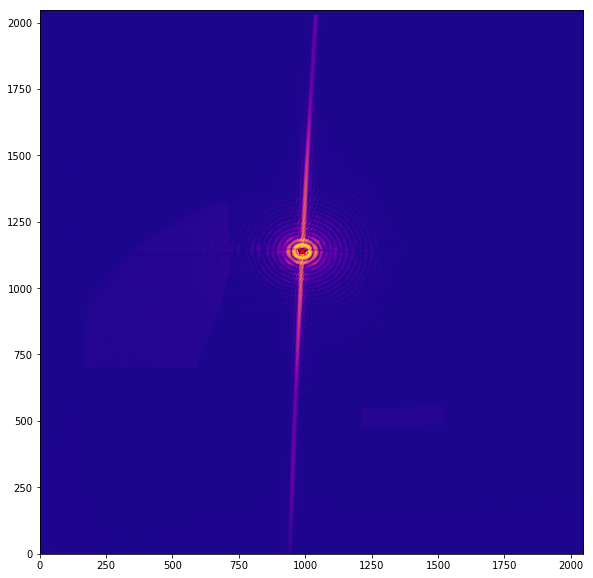

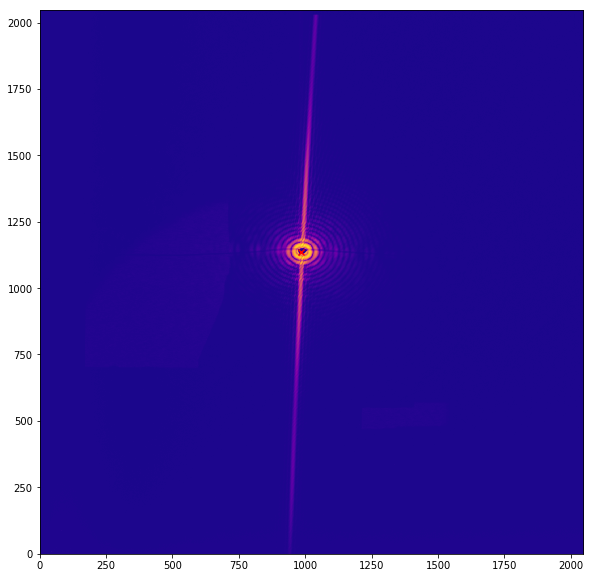

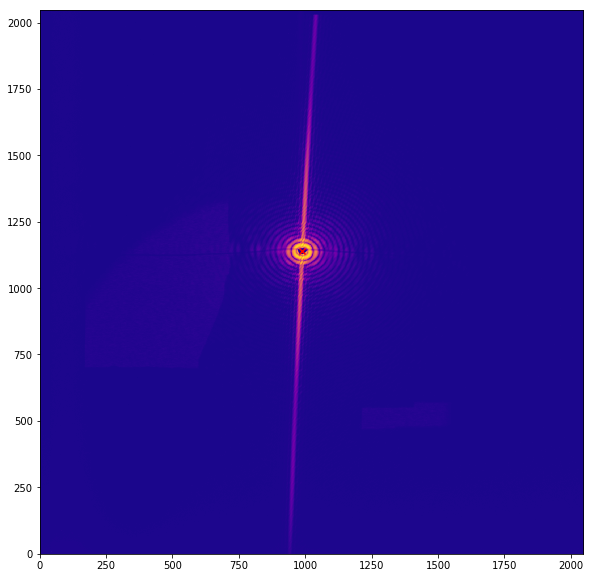

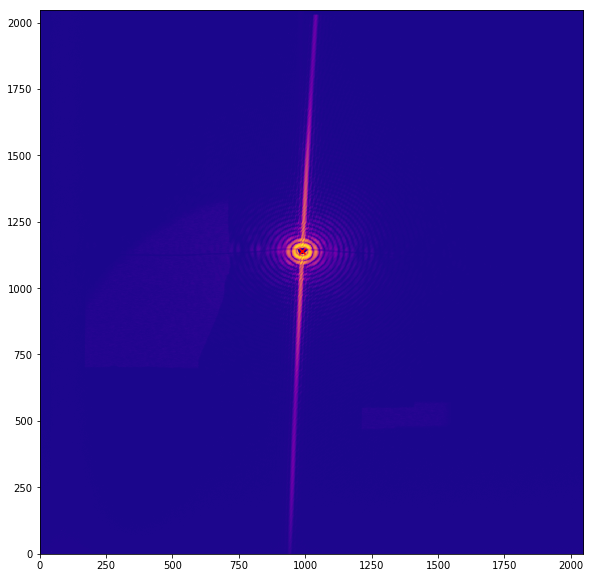

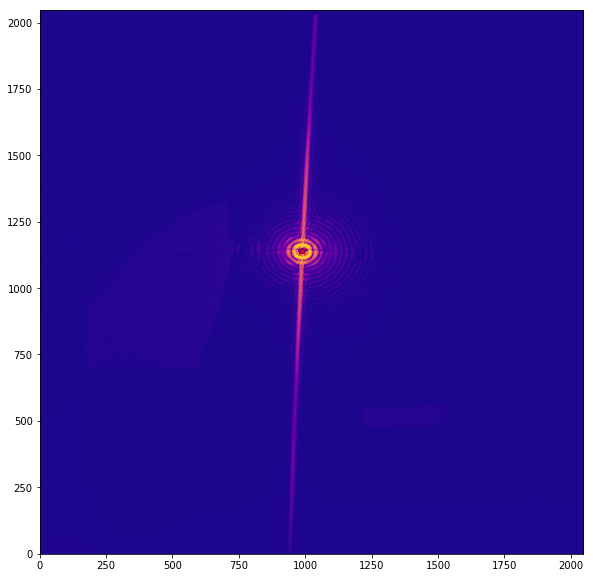

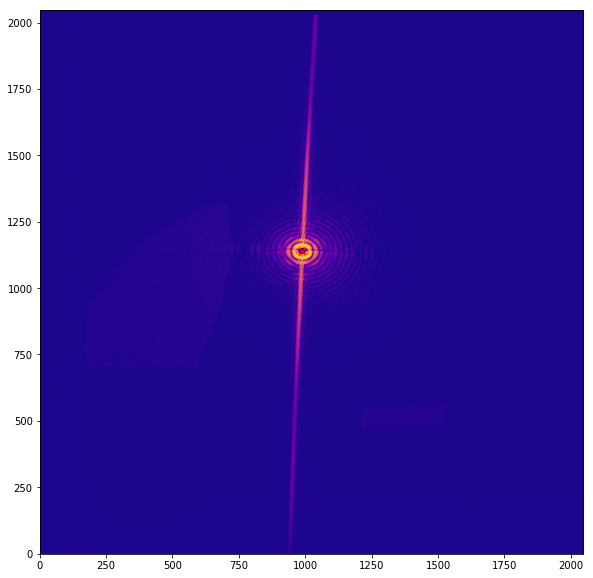

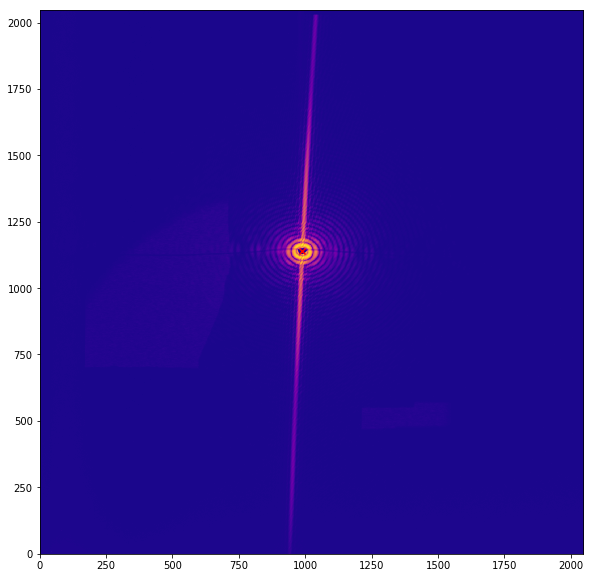

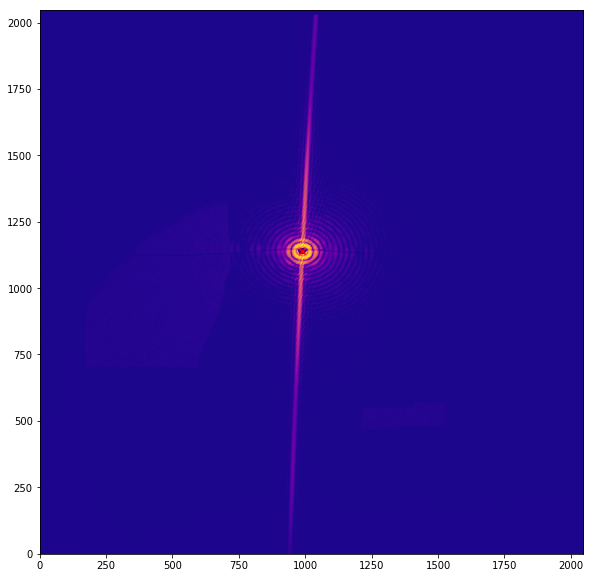

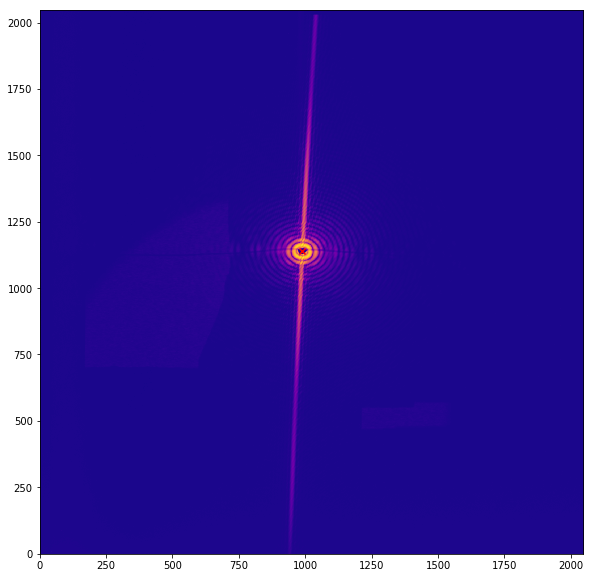

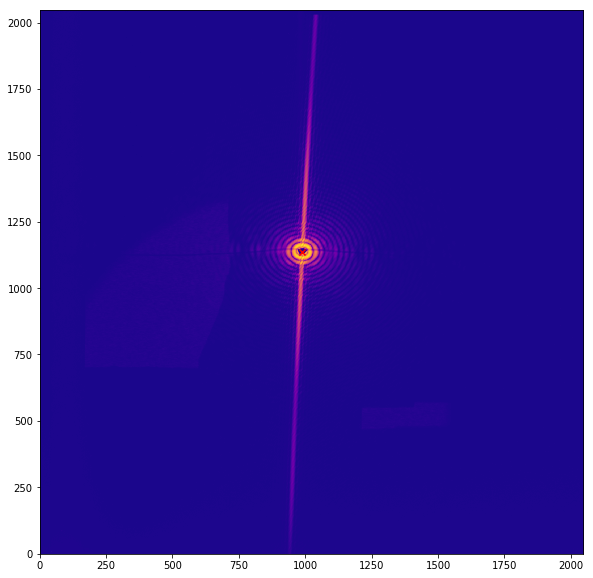

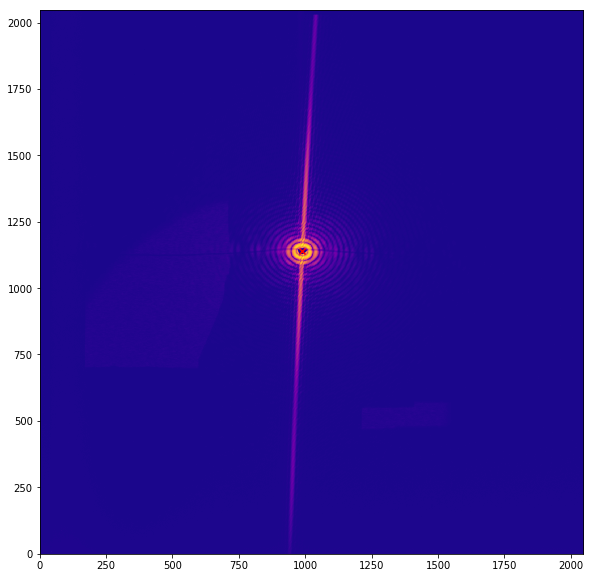

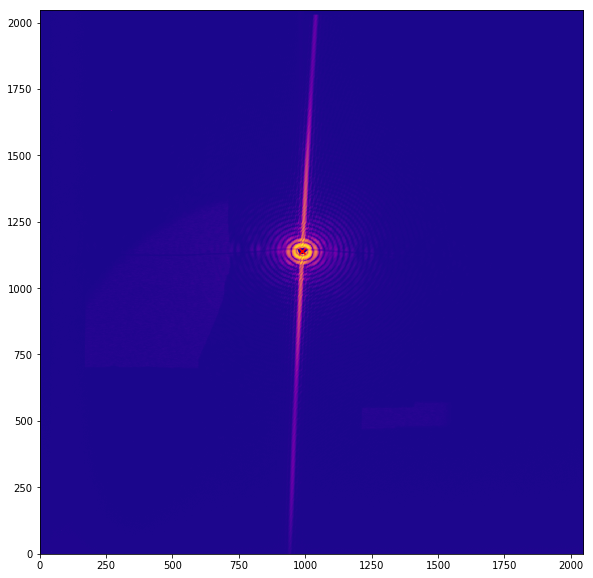

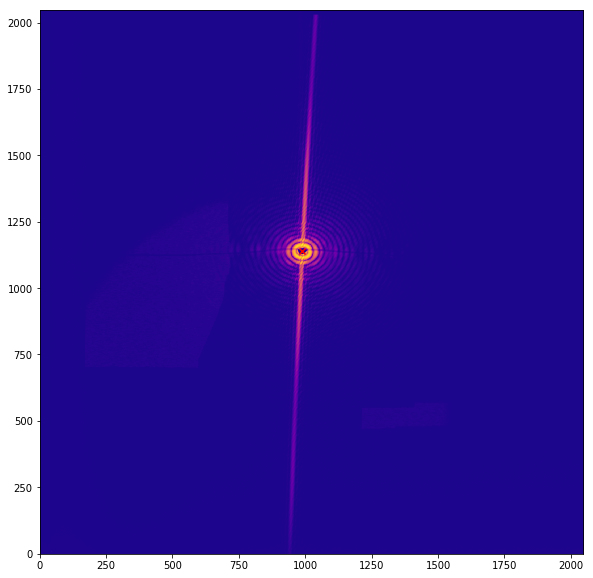

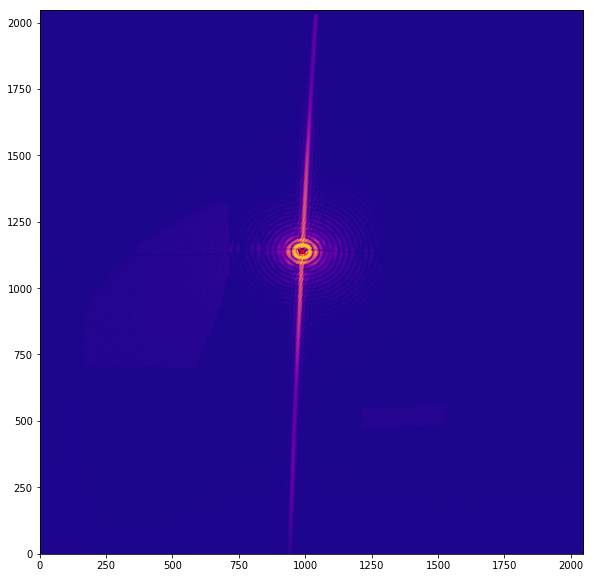

In [ ]:
# %%prun -T display_centering.txt
%matplotlib inline
import re
nxs_files = !ls *nxs
for n in range(int(len(nxs_files)/2)):
    fdir = '/Users/Angus_Laurenson/ownCloud/HERALDO_09_17/Polarity Switching/';
    fname1 = nxs_files[2*n]; fname2 = nxs_files[2*n+1];
    words = re.split(('_|\.'), fname1); dname1 = words[0] + words[2] + '_' + words[1]
    words = re.split(('_|\.'), fname2); dname2 = words[0] + words[2] + '_' + words[1]

    raw_1 = he.load_nxs_data(fdir,fname1,dname1,'data_16')
    raw_2 = he.load_nxs_data(fdir,fname2,dname2,'data_16')
    
    sum_data = raw_1 + raw_2;
    smooth_sum = sp.ndimage.gaussian_filter(sum_data, 5)
    
    origin = he.get_offset(sum_data, 5)

    plt.figure(figsize=(10,10))
    plt.imshow(ndimage.gaussian_filter(sum_data,0),
        norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03),
        origin='lower',
        cmap = 'plasma',
        interpolation='None'
    )
    plt.scatter(origin[0],origin[1], color='red', marker='x', label='centre point')
    plt.show()


